In [1]:
import pandas as pd
import os

import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point, LineString

In [2]:
lines = pd.read_excel("../lines_with_dist.xlsx", index_col=0)
stations = pd.read_excel('../stations.xlsx', index_col=0)

# Map

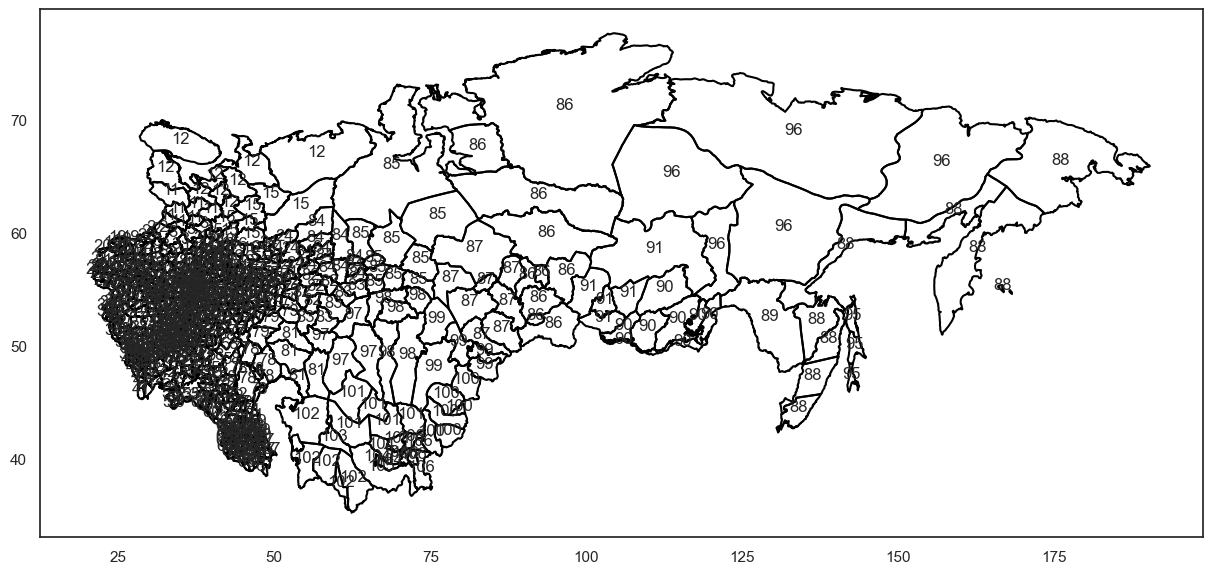

In [11]:
sns.set(style="white", palette=['black'])
sns.mpl.rc("figure", figsize=(10,6))

# provinces = gpd.read_file("../dataverse_files/provinces.gpkg")
provinces = gpd.read_file("../../data/Districts.gpkg")

finland = list(map(int, [4, 5, 10, 7, 9, 8, 6, 1]))
poland = list(map(int, [33, 34, 29, 30, 32, 27, 31, 28, 107, 25]))
siberian = list(map(int, [86, 91, 90, 96, 89, 88, 95]))
delete = ['70a', '70b', '62b', '62a']
center = list(map(int, [47, 49, 44, 50, 49]))

provinces = provinces.query('(Gub_ID not in @finland) & (Gub_ID not in @poland) & (Gub_ID not in @delete)')
# provinces = provinces.query('Gub_ID in @center')
provinces['Gub_ID'] = provinces['Gub_ID'].replace({'70b': '70', '62a': '62'})

fig, ax = plt.subplots(figsize=(15, 15))
provinces.geometry.boundary.plot(ax=ax)
provinces.apply(lambda x: ax.annotate(text=x['Gub_ID'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);


plt.plot()
plt.show()

In [12]:
railways = pd.read_csv('../all_lines_1897_changed.csv')
railways = railways.query('sector_built <= 1897')

geometry = [Point(xy) for xy in zip(railways.lon, railways.lat)]
railways = gpd.GeoDataFrame(railways, geometry=geometry, crs=4326)

In [13]:
railways = railways.query('~lat.isna()')
railways = railways.sjoin(provinces, how="inner", predicate='intersects')
railways = railways[railways.groupby(['sector_id'])['geometry'].transform('count') > 1]
railways = railways.sort_values(by=['sector_id', 'nn'])
railways = railways.groupby(['sector_id'])['geometry'].apply(lambda x: LineString(x.tolist()))
railways = gpd.GeoDataFrame(railways, geometry='geometry', crs=4326)

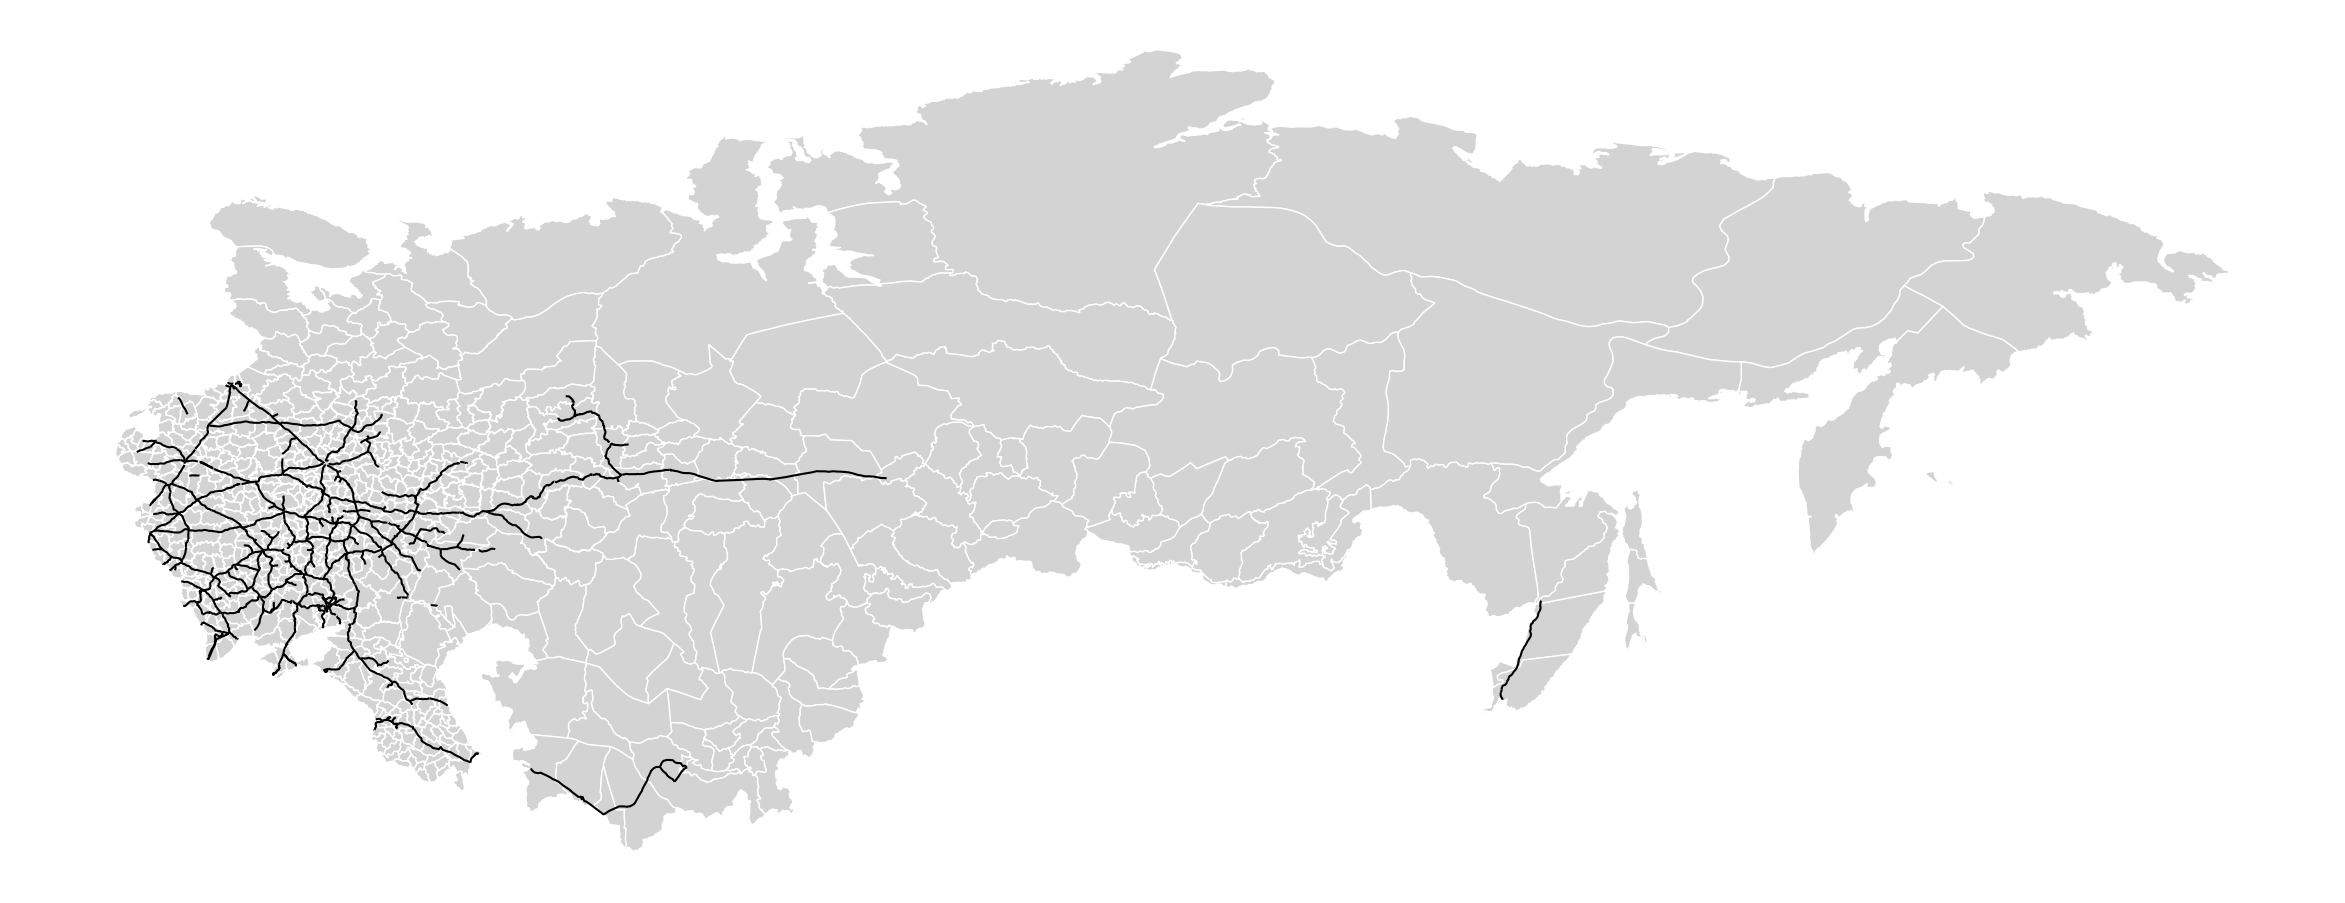

In [14]:
fig, ax = plt.subplots(figsize=(30, 30))
provinces.geometry.plot(ax=ax, color='lightgray')
railways.plot(ax=ax)
ax.set_axis_off()
plt.savefig('map_all.png')
plt.show()

# Graph

In [45]:
import networkx as nx
from libpysal import weights

/var/folders/9n/j00gw9kx3gl2_250y2w6p_096p401z/T/ipykernel_34366/2264344515.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.column_stack((provinces.centroid.x, provinces.centroid.y))
/var/folders/9n/j00gw9kx3gl2_250y2w6p_096p401z/T/ipykernel_34366/2264344515.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.column_stack((provinces.centroid.x, provinces.centroid.y))
/var/folders/9n/j00gw9kx3gl2_250y2w6p_096p401z/T/ipykernel_34366/2264344515.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen = weights.Queen.from_dataframe(provinces)
/Users/kr-safonov/miniconda

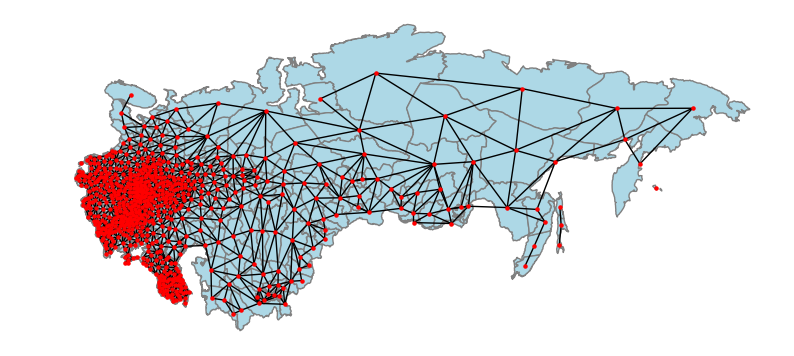

In [51]:
centroids = np.column_stack((provinces.centroid.x, provinces.centroid.y))
queen = weights.Queen.from_dataframe(provinces)
graph = queen.to_networkx()
positions = dict(zip(graph.nodes, centroids))
ax = provinces.plot(linewidth=1, edgecolor="grey", facecolor="lightblue")
ax.axis("off")
nx.draw(graph, positions, ax=ax, node_size=5, node_color="r")
plt.show()

In [90]:
import json

def save(G, positions, fname):
    s = []
    t = []
    for edge in list(G.edges()):
        s.append(int(edge[0]))
        t.append(int(edge[1]))
    
    X, Y = list(zip(*positions.values()))

    graphDict = {'s': s,
                 't': t,
                 'X': X,
                 'Y': Y}
    json.dump(graphDict, open(fname, 'w'), indent=2)

save(graph, positions, 'map.json')

# Map datasets

In [182]:
from Levenshtein import ratio

In [303]:
df = pd.read_excel('data/forKirill.xlsx')
df.province = df.province.str.replace('обл.', '')
df.province = df.province.str.replace('область', '')
df.province = df.province.str.strip()
df.district = df.district.str.replace('\d+.', '', regex=True).str.strip()

In [304]:
provinces.prov_RU = provinces.prov_RU.str.replace('губерния', '')
provinces.prov_RU = provinces.prov_RU.str.strip()
provinces = provinces.query('prov_RU != "Хива"')
provinces = provinces.query('prov_RU != "Бухара"')


In [305]:
province_mapping = dict()
for prov1 in provinces.prov_RU:
    best_prob_2 = max([(ratio(prov1, prov2), prov2) for prov2 in df.province])
    best_prob_2 = best_prob_2[1]
    province_mapping[prov1] = best_prob_2

In [307]:
provinces['prov_id'] = provinces.prov_RU.apply(province_mapping.get).apply(dict(df[['province', 'id province']].values).get)
assert ~provinces.prov_id.isna().any()

In [ ]:
def get_districts_in_prov_2(id):
    sample = df.query('`id province` == @id')\
        .query('(year == 1913) & (`id district` > 0)')\
        [['district', 'id district']].drop_duplicates()
    return dict(sample.values)
def get_districts_in_prov_1(id):
    sample = provinces.query('Gub_ID == @id')\
        [['Name_RU', 'Distr_ID']].drop_duplicates()
    return dict(sample.values)
get_districts_in_prov_2(12)

In [309]:
district_mapping = dict()
for Gub_ID in provinces.Gub_ID:
    prov2 = provinces.query('Gub_ID == @Gub_ID')['prov_id'].unique()
    assert len(prov2) == 1
    prov2 = prov2[0]
    districts_1 = get_districts_in_prov_1(Gub_ID)
    districts_2 = get_districts_in_prov_2(prov2)
    
    for dist_1 in districts_1:
        best_dist_2 = max([(ratio(dist_1, dist_2), dist_2) for dist_2 in districts_2])
        best_dist_2 = best_dist_2[1]
        district_mapping[districts_1[dist_1]] = districts_2[best_dist_2]

In [311]:
df = df.query('year == 1913')
df = df.groupby(['id province', 'id district', 'province', 'district', '1913Tpopulation'])[['YSWheat', 'YWWheat']].sum()
df = df.replace('..', 0)
df = df.sum(axis=1).to_frame('agr_output')
df = df.reset_index('1913Tpopulation')
provinces['dist_join'] = provinces['Distr_ID'].apply(district_mapping.get)
provinces = pd.merge(provinces, df,
         left_on='dist_join', right_on='id district',
         how='left')
provinces = provinces['agr_output'] / provinces['1913Tpopulation'].replace('.', '1').astype(int)

# Intersections

In [ ]:
intersections_real = []
for i in range(railways.shape[0]):
    # inter = provinces.sjoin(railways.iloc[[i]], how='inner', predicate='intersects').Gub_ID.tolist()
    inter = provinces.sjoin(railways.iloc[[i]], how='inner', predicate='intersects').Distr_ID.tolist()
    intersections_real.append(inter)

provinces = provinces.copy()
provinces[[f"path_{i}" for i in sorted(provinces.Gub_ID)]] = 0

# provinces = provinces.set_index('Gub_ID')
provinces = provinces.set_index('Distr_ID')


for i in provinces.index:
    provinces.loc[i, f"path_{i}"] = 1

# provinces = provinces.sort_values(by='Gub_ID')
provinces = provinces.sort_values(by='Distr_ID')

In [352]:
for inter in intersections_real:
    gub = inter[0]
    for j in inter[1:]:
        provinces.loc[gub, f"path_{j}"] = 1

centroids = provinces.centroid

In [354]:
paths_linestring_real = []
paths = list(filter(lambda x: len(x) > 1, intersections_real))
for path in paths:
    paths_linestring_real.append(LineString([centroids.loc[gub] for gub in path]))
paths_linestring_real = gpd.GeoDataFrame(pd.Series(paths_linestring_real, name='geometry'), geometry='geometry', crs=4326)

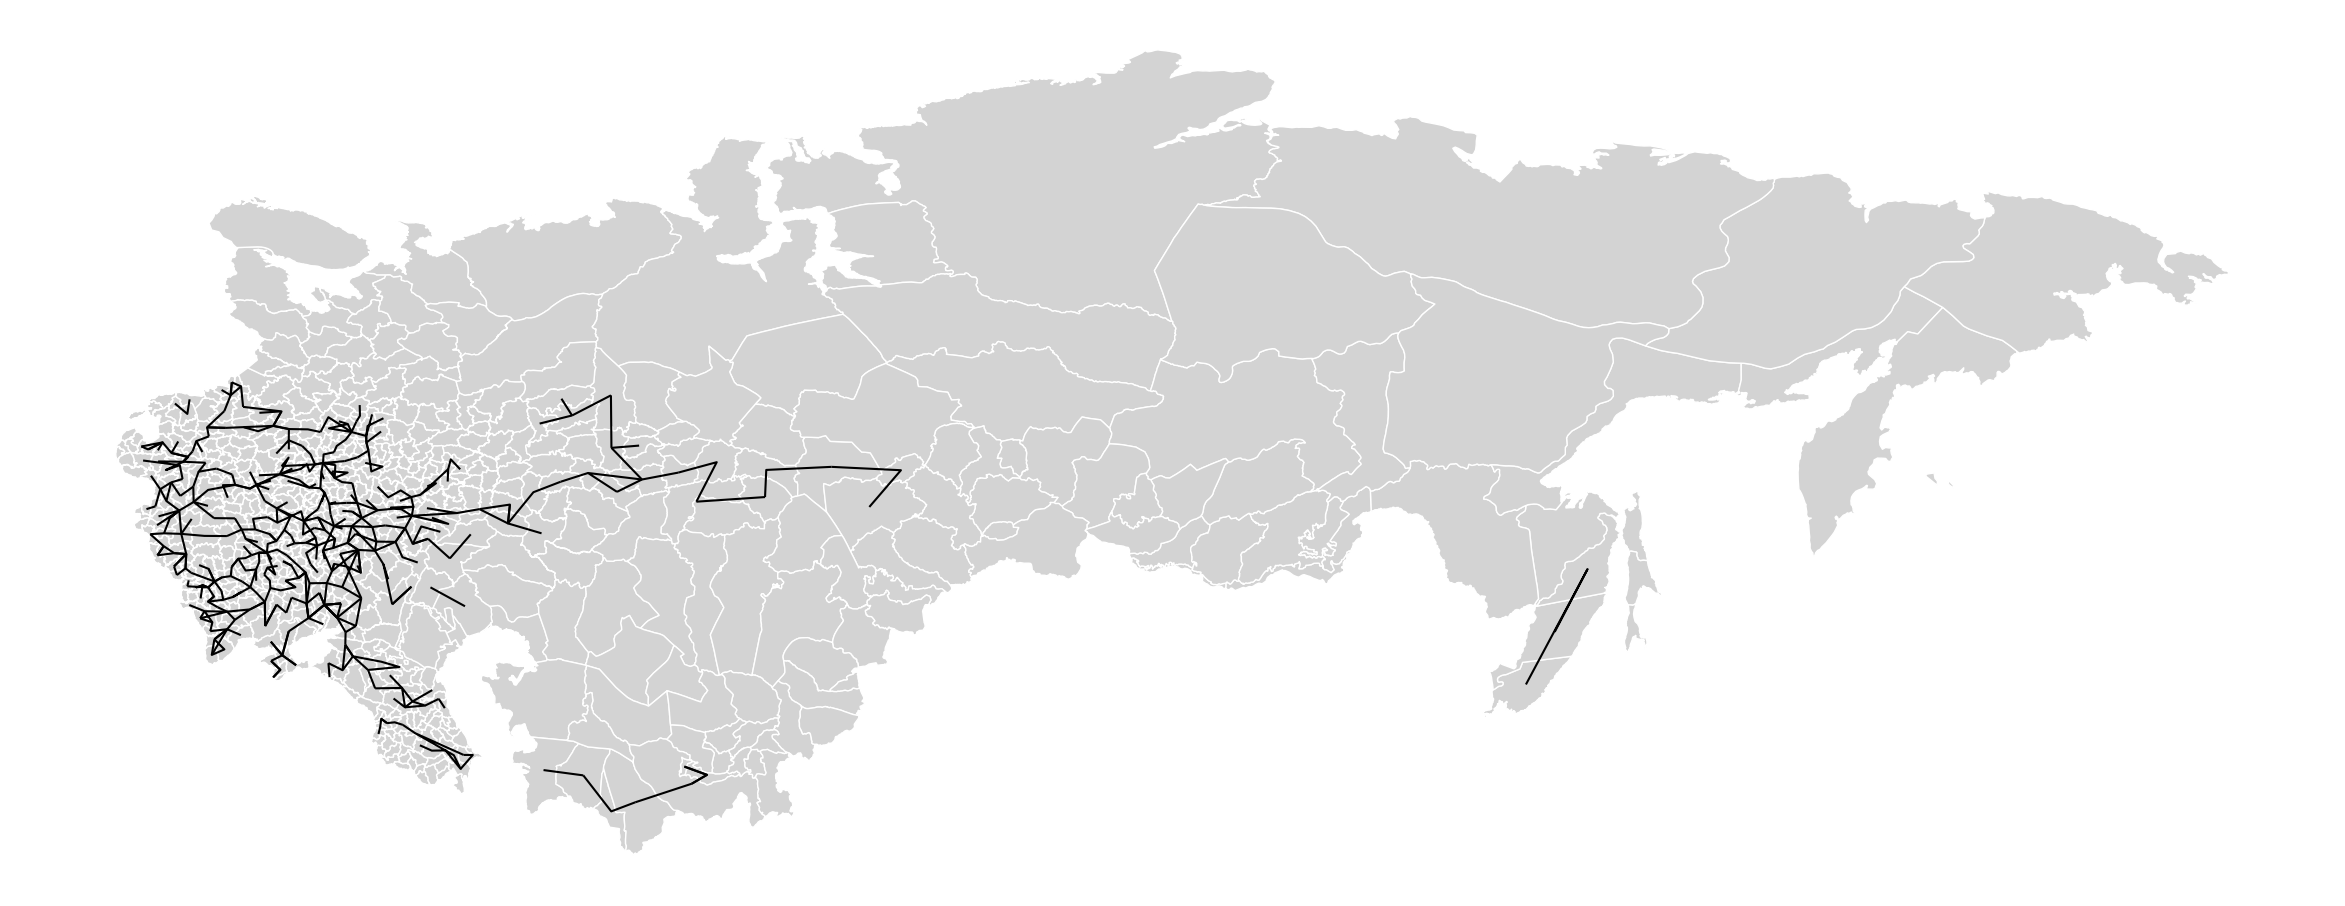

In [357]:
fig, ax = plt.subplots(figsize=(30, 30))
provinces.geometry.plot(ax=ax, color='lightgray')
# centroids.loc[np.unique(np.concatenate(list(filter(lambda x: len(x) > 1, intersections))))].plot(marker='s', ax=ax)
paths_linestring_real.plot(ax=ax)
ax.set_axis_off()
plt.savefig('map_all_discrete.png')
plt.show()

In [236]:
provinces = provinces.reset_index()

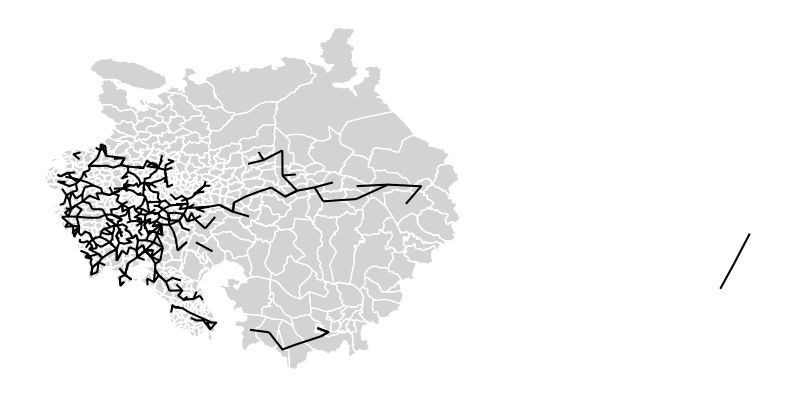

In [237]:
fig, ax = plt.subplots(figsize=(10, 10))
provinces.query('Gub_ID not in @siberian').geometry.plot(ax=ax, color='lightgray')
# centroids.loc[np.unique(np.concatenate(list(filter(lambda x: len(x) > 1, intersections))))].plot(marker='s', ax=ax)
paths_linestring_real.plot(ax=ax)
ax.set_axis_off()
plt.savefig('discrete_urk.png')
plt.show()

In [386]:
y, X = list(), list()

for pair in all_pairs:
    if pair in real_pairs:
        y.append(1)
    else:
        y.append(0)

    if pair in optimal_pairs:
        X.append(1)
    else:
        X.append(0)
    